In [1]:
import datetime
import os

import torch
import torch.nn as nn
from torch.optim.lr_scheduler import ReduceLROnPlateau, ExponentialLR
from torch.utils.data import Dataset, DataLoader, IterableDataset

import numpy as np
import pandas as pd

from collections import Counter, defaultdict, OrderedDict

from sklearn.metrics import precision_score, f1_score, recall_score, classification_report, confusion_matrix, make_scorer
from sklearn.model_selection import StratifiedKFold
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Consider ragas that have at least 10 samples.
RAGAM_MIN_COUNT = 30

In [4]:
data = pd.read_json('/content/drive/MyDrive/song_lyric_map.json')
adata = pd.read_json('/content/drive/MyDrive/mp3_data_genres.json')

In [5]:
IMG_PATH = '/content/drive/MyDrive/melSpectrogram'
AUD_PATH = '/content/drive/MyDrive/Annamayya'
VOCAL_MFCC_PATH = '/content/drive/MyDrive/vocal_mfcc'

In [6]:
data['exists'] = data.apply(lambda x:os.path.exists(os.path.join(AUD_PATH,x['MP3 File'])),axis=1)
data = data[data.exists]

In [7]:
def get_offset(adata, id):
  l = adata[adata.Samputi==id]['Offset'].tolist()
  return 0 if len(l) == 0 else l[0]
data['Offset'] = data.apply(lambda x:get_offset(adata, x.Samputi), axis=1)

In [8]:
all_samples = data.Ragam.value_counts().index
low_samples = all_samples[data.Ragam.value_counts()<RAGAM_MIN_COUNT]
# Drop these rows.
for s in low_samples:
  data = data[data.Ragam!=s]

In [9]:
le = LabelEncoder()
le.fit_transform(data['Ragam'])
data['RagamCode'] = data.apply(lambda x:le.transform([x.Ragam])[0],axis=1)
n_labels = len(data['RagamCode'].unique())

In [10]:
data['Ragam'].value_counts()

లలిత          98
సాళంగనాట      94
సామంతం        89
బౌళి          70
శంకరాభరణం     68
శ్రీరాగం      65
రామక్రియ      61
ముఖారి        55
పాడి          50
ఆహిరి         45
దేసాళం        40
దేవగాంధారి    35
శుద్ధవసంతం    33
భూపాలం        32
Name: Ragam, dtype: int64

In [11]:
print(f'Unique Ragas : {n_labels}')

Unique Ragas : 14


In [12]:
for c in le.classes_:
  print(f'{c} : {le.transform([c])}')

ఆహిరి : [0]
దేవగాంధారి : [1]
దేసాళం : [2]
పాడి : [3]
బౌళి : [4]
భూపాలం : [5]
ముఖారి : [6]
రామక్రియ : [7]
లలిత : [8]
శంకరాభరణం : [9]
శుద్ధవసంతం : [10]
శ్రీరాగం : [11]
సామంతం : [12]
సాళంగనాట : [13]


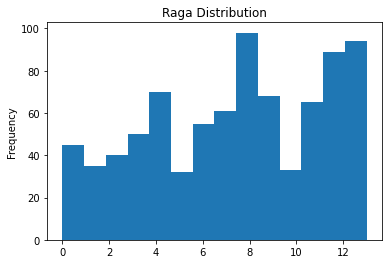

In [13]:
data['RagamCode'].plot.hist(bins=n_labels)
plt.title('Raga Distribution')
plt.show()

In [14]:
data['Offset'].fillna(60,inplace=True)

In [15]:
def get_devices():
    if torch.cuda.is_available():
        gpu = torch.device("cuda")
    else:
        gpu = torch.device("cpu")
    cpu = torch.device("cpu")
    return gpu, cpu
gpu, cpu = get_devices()

In [16]:
def get_loss_function(balance_classes, labels, run_on, loss_fcn=nn.CrossEntropyLoss):
    if balance_classes:
        class_wts = compute_class_weight('balanced',
                                         np.unique(labels),
                                         labels
                                         )
        print(f'Class Weights : {class_wts}')
        # convert class weights to tensor
        weights = torch.tensor(class_wts, dtype=torch.float)
        weights = weights.to(run_on)
        # loss function
        loss_fcn = loss_fcn(weight=weights)
    else:
        loss_fcn = loss_fcn()
    return loss_fcn

In [17]:
def update_best_result(best_scores, valid_loss, train_labels, train_predictions, test_labels, test_predictions,
                       model=None, model_file_name=f'saved_weights_Fold_0.pt'):
    if valid_loss < best_scores['valid_loss']:
        best_scores['valid_loss'] = valid_loss
        best_scores['train_predictions'] = train_predictions
        best_scores['test_predictions'] = test_predictions
        best_scores['train_labels'] = train_labels
        best_scores['test_labels'] = test_labels
        if model:
            torch.save(model.state_dict(), model_file_name)
    return best_scores

In [18]:
def update_results_dict(results, train_labels, train_predictions, test_labels, test_predictions):
    s = 'micro'
    results['train_precision'].append(precision_score(train_labels, train_predictions,average=s))
    results['train_recall'].append(recall_score(train_labels, train_predictions,average=s))
    results['train_f1'].append(f1_score(train_labels, train_predictions,average=s))
    results['validation_precision'].append(precision_score(test_labels, test_predictions,average=s))
    results['validation_recall'].append(recall_score(test_labels, test_predictions,average=s))
    results['validation_f1'].append(f1_score(test_labels, test_predictions,average=s))
    return results

In [19]:
def run_model(model, dataset, loss_fcn, optimizer, is_training, run_on, clip_at=None, lstm_model=False, report_at=20):
  predict = lambda model, data, hidden: model(data, hidden) if hidden else model(data)
  hid = lambda model, data, run_on, lstm_model: model.init_hidden(data.shape[0], run_on) if lstm_model else None
  if is_training:
      print('Training Model')
      model.train()
  else:
      print('Evaluating Model')
      model.eval()
  total_loss, total_accuracy, model_predictions, model_labels, aud_data = 0, 0, [], [], None
  for step, batch in enumerate(dataset):
      if step % report_at == 0 and not step == 0:
          print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(dataset)))
      # push the batch to gpu
      batch = [r.to(run_on) for r in batch]        
      aud_data, labels = batch
      h = hid(model, aud_data, run_on, lstm_model)
      if is_training:
          for o in optimizer: o.zero_grad()
          model.zero_grad()
          predictions = predict(model, aud_data, h)
      else:
          with torch.no_grad():
            predictions = predict(model, aud_data, h)
      # compute the loss between actual and predicted values
      loss = loss_fcn(predictions, labels)
      predictions = predictions.detach().cpu().numpy()
      total_loss = total_loss + loss.item()
      if is_training:
          loss.backward()  # backward pass to calculate the gradients
          if clip_at:
              torch.nn.utils.clip_grad_norm_(model.parameters(), clip_at)
          # update parameters
          for o in optimizer: o.step()
      # append the model predictions
      model_predictions.append(predictions)
      model_labels.append(labels.detach().cpu().numpy())
      del batch
  # compute the training loss of the epoch
  avg_loss = total_loss / len(dataset)
  # predictions are in the form of (no. of batches, size of batch, no. of classes).
  # reshape the predictions in form of (number of samples, no. of classes)
  model_predictions = np.concatenate(model_predictions, axis=0)
  model_labels = np.concatenate(model_labels, axis=0)
  # returns the loss and predictions
  model_predictions = np.argmax(model_predictions, axis=1)
  return avg_loss, model_predictions, model_labels, model

In [20]:
def plot_results(results, model_name):
    fig = plt.figure(figsize=[20, 10])
    epochs = len(results[0]['train_precision'])
    x_label = f'{len(results)} Fold and {epochs} Epochs'
    legend_labels = ['Train', 'Val']

    def subplot_routine(key1, key2, title, loss=False):
        plt.plot([x for k in results for x in results[k][key1]])
        plt.plot([x for k in results for x in results[k][key2]])
        plt.grid()
        plt.xlabel(x_label)
        plt.legend([f'{x} {title}' for x in legend_labels])
        if not loss:
            plt.ylim([0, 1.1])
        else:
            b, t = plt.ylim()
            plt.ylim(np.floor(b), np.ceil(t))

    gs = GridSpec(2, 3, figure=fig)
    plt.subplot(gs.new_subplotspec((0, 0), colspan=3))
    subplot_routine('train_losses', 'validation_losses', 'Losses', True)
    plt.subplot(2, 3, 4)
    subplot_routine('train_precision', 'validation_precision', 'Precision')
    plt.subplot(2, 3, 5)
    subplot_routine('train_recall', 'validation_recall', 'Recall')
    plt.subplot(2, 3, 6)
    subplot_routine('train_f1', 'validation_f1', 'F1')
    plt.suptitle(f'Metrics for {model_name}')
    plt.tight_layout()
    plt.show()

In [21]:
class AbsDataset(IterableDataset):
  def __init__(self):
    super().__init__()
  
  def get_data_loader(self, batch_size=32, random_seed=42):
    g = torch.Generator()
    g.manual_seed(random_seed)
    return DataLoader(self, batch_size=batch_size, generator=g)

In [22]:
def train_model(data, prepare_data_hnd, gpu, **kwargs):
  torch.manual_seed(42)
  start_time = datetime.datetime.now()

  n_labels = kwargs['n_labels']
  title = kwargs['title']
  report = kwargs['report'] if 'report' in kwargs else 20
  lstm = kwargs['lstm'] if 'lstm' in kwargs else False
  lr = kwargs['lr'] if 'lr' in kwargs else 1e-4
  clip_at = kwargs['clip_at'] if 'clip_at' in kwargs else None
  k_folds = kwargs['k_folds'] if 'k_folds' in kwargs else 5
  balance_classes = kwargs['balance_classes'] if 'balance_classes' in kwargs else True
  dropout = kwargs['dropout'] if 'dropout' in kwargs else 0.25
  plot = kwargs['plot'] if 'plot' in kwargs else True
  epochs = kwargs['epochs'] if 'epochs' in kwargs else 5
  mdlargs = kwargs['mdlargs'] if 'mdlargs' in kwargs else {}
  
  k_fold = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)
  results = {x: {} for x in range(k_folds)}
  labels = data['RagamCode']
  for fold, (train_ids, test_ids) in enumerate(k_fold.split(data[['mfcc_mean']], data['RagamCode'])):
    print(f'FOLD {fold} \n Data Sizes (Train/Test) : {len(train_ids)}/{len(test_ids)}')
    fold_start = datetime.datetime.now()
    # empty lists to store training and validation loss of each epoch
    train_losses, valid_losses = [], []
    best_scores = {'valid_loss': float('inf'),
                    'train_predictions': [],
                    'test_predictions': [],
                    'train_labels': [],
                    'test_labels': []
                    }
    # for each epoch
    results[fold] = {
        'train_f1': [],
        'validation_f1': [],
        'train_precision': [],
        'validation_precision': [],
        'train_recall': [],
        'validation_recall': []
    }
    train_data, test_data, train_lbls, test_lbls = prepare_data_hnd(data, train_ids, test_ids)
    model = kwargs['model'](n_labels,dropout=dropout,**mdlargs)
    model.to(gpu)
    loss_fcn = get_loss_function(balance_classes, data['RagamCode'].tolist(), gpu, nn.CrossEntropyLoss)
    # define the optimizer
    optimizer = [torch.optim.Adam(model.parameters(), lr=lr)]
    lr_schedulers = [ReduceLROnPlateau(optimizer[0], patience=3,factor=0.1,threshold=1e-9,mode='min'),
                     ExponentialLR(optimizer[0],gamma=0.9)]
    for epoch in range(epochs):
        e_start = datetime.datetime.now()
        print('Epoch {:} / {:}'.format(epoch + 1, epochs))
        # train model
        train_loss, train_predictions, train_labels, model = run_model(model, train_data.get_data_loader(batch_size=32),
                                                                        loss_fcn, optimizer, run_on=gpu,
                                                                        is_training=True, clip_at=clip_at,
                                                                       lstm_model=lstm, report_at=report)
        # evaluate model
        valid_loss, test_predictions, test_labels, model = run_model(model, test_data.get_data_loader(batch_size=32),
                                                                      loss_fcn, optimizer, run_on=gpu,
                                                                      is_training=False, clip_at=clip_at,
                                                                     lstm_model=lstm, report_at=report)
        print(f'Losses - Train : {train_loss:.3f} / Validation : {valid_loss:.3f}')
        for lr_scheduler in lr_schedulers:
            lr_scheduler.step(valid_loss)
        torch.cuda.empty_cache()
        # save the best model
        best_scores = update_best_result(best_scores,
                                          valid_loss,
                                          train_labels, train_predictions,
                                          test_labels, test_predictions,
                                          model=model,
                                          model_file_name=f'saved_weights_Fold_{fold}.pt')
        # append training and validation loss
        train_losses.append(train_loss)
        valid_losses.append(valid_loss)
        results[fold] = update_results_dict(results[fold],
                                            train_labels, train_predictions,
                                            test_labels, test_predictions)
        e_end = datetime.datetime.now()
        print(f'Time for epoch : {(e_end - e_start).total_seconds()} seconds')
    print('On Train Data')
    print(classification_report(best_scores['train_labels'], best_scores['train_predictions']))
    print('On Test Data')
    print(classification_report(best_scores['test_labels'], best_scores['test_predictions']))
    results[fold]['train_losses'] = train_losses
    results[fold]['validation_losses'] = valid_losses
    print(f'Time for fold {fold} : {(datetime.datetime.now() - fold_start).total_seconds()} seconds')
  end_time = datetime.datetime.now()
  print(f'Overall Time : {(end_time - start_time).total_seconds()} seconds')
  print('*** Confusion Matrix - Training ***')
  print(confusion_matrix(train_predictions,train_labels))
  print('*** Confusion Matrix - Validation ***')
  print(confusion_matrix(test_predictions,test_labels))
  if plot:
    plot_results(results, title)
  return results

In [23]:
def results_to_df(results):
    p = pd.DataFrame(results[0])
    for i in range(1, len(results)):
        p = pd.concat([p, pd.DataFrame(results[i])], axis=0)
    p.sort_values(by='validation_f1', ascending=False, inplace=True)
    return p

In [24]:
def get_mfcc(x, aud_path):
  aud_path = os.path.join(aud_path, x['MP3 File'] + '.pt')
  if os.path.exists(aud_path):
    x = torch.load(aud_path)
  else:
    x = []
  return x
data['vocal_mfcc'] = data.apply(lambda x:get_mfcc(x, VOCAL_MFCC_PATH),axis=1)

In [25]:
data = data[data.apply(lambda x:not isinstance(x['vocal_mfcc'],list),axis=1)]

# Experiment 1 - Vocal MFCC Feed Forward

In [27]:
class MfccMatrixDataset(AbsDataset):
    def __init__(self, labels, mfcc_vals):
        super().__init__()
        self.labels = labels
        self.mfcc_vals = mfcc_vals

    def __get__(self,index):
      if len(self.mfcc_vals[index].shape) == 3:
        self.mfcc_vals[index] = self.mfcc_vals[index].reshape((self.mfcc_vals[index].shape[1],self.mfcc_vals[index].shape[2]))
      if self.mfcc_vals[index].shape[1] < 9601:
        self.mfcc_vals[index] = torch.hstack((self.mfcc_vals[index],torch.zeros(40,9601-self.mfcc_vals[index].shape[1])))
      return self.mfcc_vals[index].reshape((1,)+self.mfcc_vals[index].shape)

    def __len__(self):
        return len(self.labels)

    def __iter__(self):
        for index, _ in enumerate(self.labels):
            yield self.__get__(index), self.labels[index]

    def __getitem__(self, index):
        return self.__get__(index), self.labels[index]

    @staticmethod
    def prepare_data(data, train_ids, test_ids):
      train_lbls = torch.tensor([data['RagamCode'].iloc[x] for x in train_ids])
      test_lbls = torch.tensor([data['RagamCode'].iloc[x] for x in test_ids])
      train_vals = [data['vocal_mfcc'].iloc[x] for x in train_ids]
      test_vals = [data['vocal_mfcc'].iloc[x] for x in test_ids]
      train_data = MfccMatrixDataset(train_lbls, train_vals)
      test_data = MfccMatrixDataset(test_lbls, test_vals)
      return train_data, test_data, train_lbls, test_lbls

In [28]:
class MfccRaga(nn.Module):
    def __init__(self, n_labels, dropout=0.25):
        super().__init__()
        self.height = 40
        self.width = 9601
        # Fully connected audio layer with MFCC Matrix 40x9601 (120secs)
        pool_kernel = 2
        kernel = (2,2)
        self.layers1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=4, kernel_size=kernel, padding='same'),            
            nn.GELU(),
            nn.Conv2d(in_channels=4, out_channels=8, kernel_size=kernel, padding='same'),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.AvgPool2d(kernel_size=pool_kernel),
            nn.Flatten()
        )
        self.final = nn.Linear(768000,n_labels)
        
    def forward(self,x):
        x = self.layers1(x)
        x = self.final(x)
        return x

FOLD 0 
 Data Sizes (Train/Test) : 566/142
Class Weights : [1.36679537 1.53246753 1.53246753 1.2967033  0.85714286 1.87301587
 1.2967033  1.03206997 0.5682183  0.90306122 1.58035714 0.85714286
 0.6567718  0.64014467]
Epoch 1 / 15
Training Model
Evaluating Model
Losses - Train : 2.802 / Validation : 2.822
Time for epoch : 3.222532 seconds
Epoch 2 / 15
Training Model
Evaluating Model
Losses - Train : 2.498 / Validation : 2.794
Time for epoch : 2.805144 seconds
Epoch 3 / 15
Training Model
Evaluating Model
Losses - Train : 2.309 / Validation : 2.788
Time for epoch : 2.781445 seconds
Epoch 4 / 15
Training Model
Evaluating Model
Losses - Train : 2.145 / Validation : 2.786
Time for epoch : 2.780509 seconds
Epoch 5 / 15
Training Model
Evaluating Model
Losses - Train : 1.990 / Validation : 2.785
Time for epoch : 2.78709 seconds
Epoch 6 / 15
Training Model
Evaluating Model
Losses - Train : 1.840 / Validation : 2.785
Time for epoch : 2.795044 seconds
Epoch 7 / 15
Training Model
Evaluating Model
L

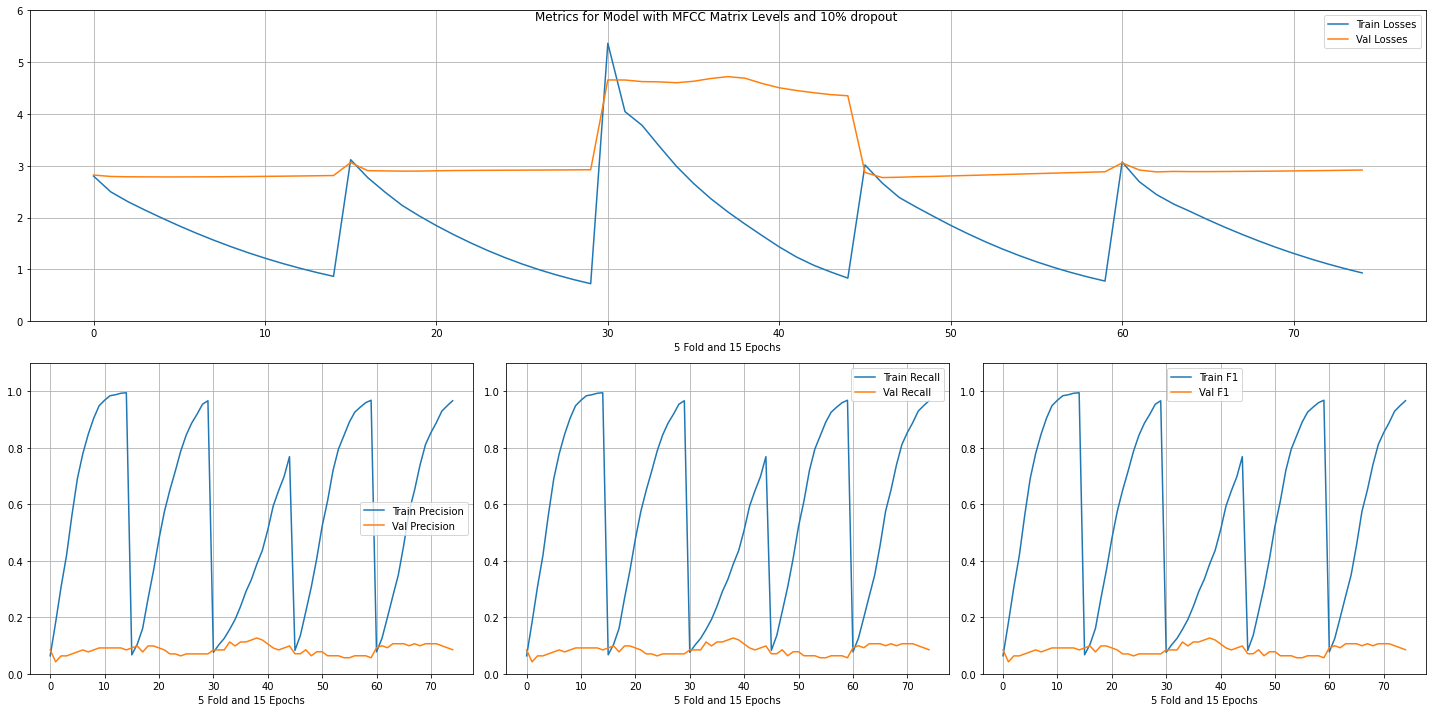

In [29]:
mfcc_matrix_results = train_model(data, MfccMatrixDataset.prepare_data, gpu, 
                                  **{'n_labels' : n_labels,
                                   'report' : 20,
                                   'lstm' : False,
                                   'lr' : 1e-6,
                                   'clip_at' : None,
                                   'k_folds' : 5,
                                   'balance_classes' : True,
                                   'dropout' : 0,
                                   'title' : 'Model with MFCC Matrix Levels and 10% dropout',
                                   'plot' : True,
                                   'epochs' : 15,
                                   'model' : MfccRaga})

# Experiment 2 - Mean Vocal MFCC Levels

In [30]:
data['vocal_mfcc_mean'] = data.apply(lambda x:x.vocal_mfcc.mean(dim=2),axis=1)

In [31]:
class MfccMeanDataset(AbsDataset):
    def __init__(self, labels, mfcc_vals):
        super().__init__()
        self.labels = labels
        self.mfcc_vals = mfcc_vals

    def __len__(self):
        return len(self.labels)

    def __iter__(self):
        for index, _ in enumerate(self.labels):
            yield self.mfcc_vals[index].reshape(40), self.labels[index]

    def __getitem__(self, index):
        return self.mfcc_vals[index].reshape(40), self.labels[index]

    @staticmethod
    def prepare_data(data, train_ids, test_ids):
      train_lbls = torch.tensor([data['RagamCode'].iloc[x] for x in train_ids])
      test_lbls = torch.tensor([data['RagamCode'].iloc[x] for x in test_ids])
      train_vals = [data['vocal_mfcc_mean'].iloc[x] for x in train_ids]
      test_vals = [data['vocal_mfcc_mean'].iloc[x] for x in test_ids]
      train_data = MfccMeanDataset(train_lbls, train_vals)
      test_data = MfccMeanDataset(test_lbls, test_vals)
      return train_data, test_data, train_lbls, test_lbls

In [32]:
class MfccFtVecRaga(nn.Module):
    def __init__(self, n_labels, dropout=0.25):
        super().__init__()
        self.n_labels = n_labels
        self.mfcc = nn.Sequential(
            nn.Linear(40, 80), nn.LeakyReLU(),
            nn.Linear(80, 160), nn.LeakyReLU(), nn.Dropout(dropout),
            nn.Linear(160, 320), nn.LeakyReLU(), nn.Dropout(dropout),
            nn.Linear(320, self.n_labels)
        )
        
    def forward(self,x):
        return self.mfcc(x)

FOLD 0 
 Data Sizes (Train/Test) : 566/142
Class Weights : [1.36679537 1.53246753 1.53246753 1.2967033  0.85714286 1.87301587
 1.2967033  1.03206997 0.5682183  0.90306122 1.58035714 0.85714286
 0.6567718  0.64014467]
Epoch 1 / 100
Training Model
Evaluating Model
Losses - Train : 4.341 / Validation : 3.392
Time for epoch : 0.097444 seconds
Epoch 2 / 100
Training Model
Evaluating Model
Losses - Train : 4.239 / Validation : 3.283
Time for epoch : 0.067089 seconds
Epoch 3 / 100
Training Model
Evaluating Model
Losses - Train : 4.088 / Validation : 3.193
Time for epoch : 0.071823 seconds
Epoch 4 / 100
Training Model
Evaluating Model
Losses - Train : 4.074 / Validation : 3.117
Time for epoch : 0.070778 seconds
Epoch 5 / 100
Training Model
Evaluating Model
Losses - Train : 4.011 / Validation : 3.056
Time for epoch : 0.067115 seconds
Epoch 6 / 100
Training Model
Evaluating Model
Losses - Train : 3.787 / Validation : 3.005
Time for epoch : 0.07291 seconds
Epoch 7 / 100
Training Model
Evaluating 

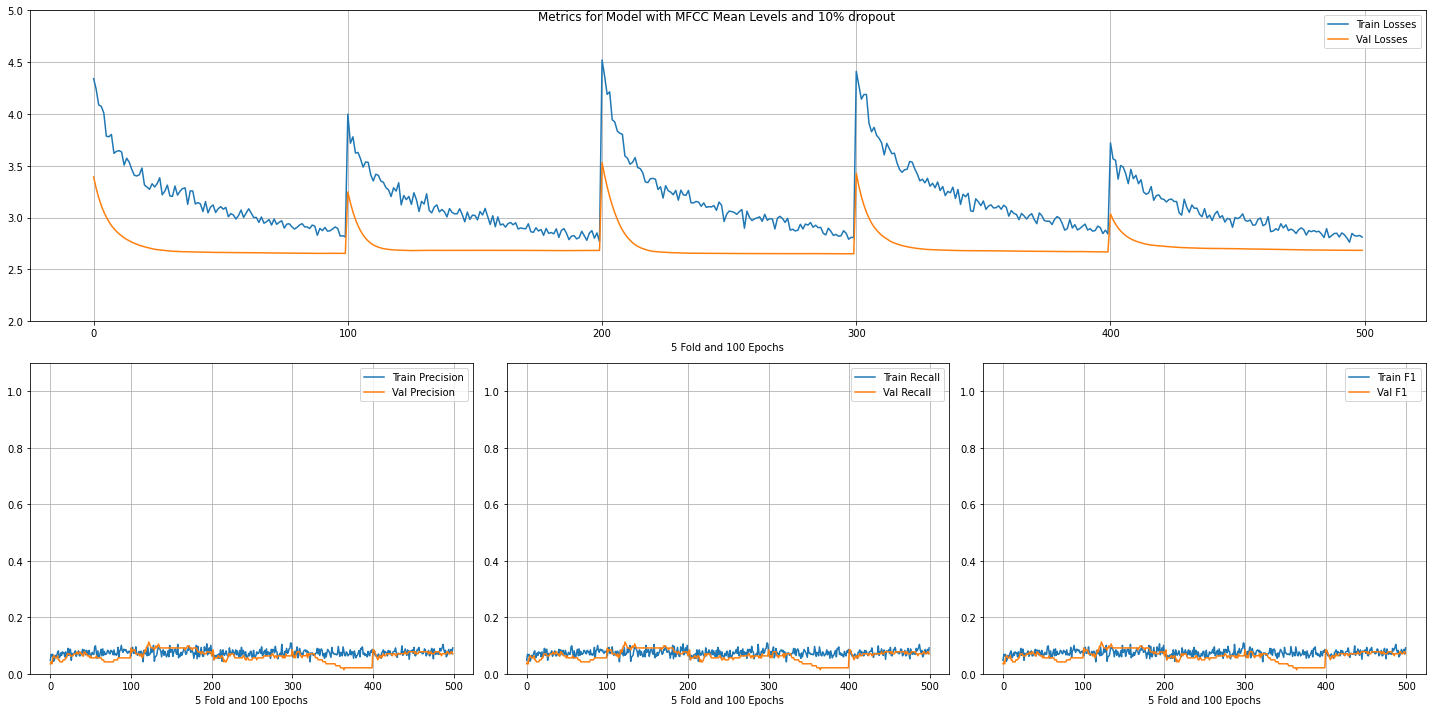

In [33]:
mfcc_single_results = train_model(data, MfccMeanDataset.prepare_data, gpu, 
                                  **{'n_labels' : n_labels,
                                   'report' : 50,
                                   'lstm' : False,
                                   'lr' : 1e-5,
                                   'clip_at' : None,
                                   'k_folds' : 5,
                                   'balance_classes' : True,
                                   'dropout' : 0.3,
                                   'title' : 'Model with MFCC Mean Levels and 10% dropout',
                                   'plot' : True,
                                   'epochs' : 100,
                                   'model' : MfccFtVecRaga})

# Experiment 3 - Vocal MFCC LSTM Model

In [43]:
class MfccLstmModel(nn.Module):
    def __init__(self, n_labels, dropout=0.25, n_layers=2):
        super().__init__()
        self.input_dim = 40
        self.hidden_dim = self.input_dim
        self.n_layers = n_layers
        self.seq_len = 9601
        self.n_labels = n_labels
        self.rnn = nn.LSTM(self.input_dim, self.hidden_dim, self.n_layers, batch_first=True, bidirectional=True, dropout=dropout)
        self.fc = nn.Sequential(nn.Linear(2*self.hidden_dim,160),
                                nn.GELU(),
                                nn.Linear(160,self.n_labels))

    def forward(self,x,h):
        x = x.reshape((x.shape[0],x.shape[2],x.shape[3]))
        out, (hn, cn) = self.rnn(x.permute(0, 2, 1), h)
        x_forward = out[range(len(out)), self.seq_len - 1, :self.hidden_dim]
        x_reverse = out[:, 0, self.hidden_dim:]
        x = torch.cat((x_forward, x_reverse), 1)
        x = self.fc(x)
        return x
    
    def init_hidden(self, batch_size, target_device):
        weight = next(self.parameters()).data
        # Bi directional LSTM
        hidden = (weight.new(2 * self.n_layers, batch_size, self.hidden_dim).zero_().to(target_device),
                  weight.new(2 * self.n_layers, batch_size, self.hidden_dim).zero_().to(target_device))
        return hidden

FOLD 0 
 Data Sizes (Train/Test) : 566/142
Class Weights : [1.36679537 1.53246753 1.53246753 1.2967033  0.85714286 1.87301587
 1.2967033  1.03206997 0.5682183  0.90306122 1.58035714 0.85714286
 0.6567718  0.64014467]
Epoch 1 / 15
Training Model
Evaluating Model
Losses - Train : 2.650 / Validation : 2.659
Time for epoch : 35.91 seconds
Epoch 2 / 15
Training Model
Evaluating Model
Losses - Train : 2.620 / Validation : 2.649
Time for epoch : 35.452468 seconds
Epoch 3 / 15
Training Model
Evaluating Model
Losses - Train : 2.510 / Validation : 2.795
Time for epoch : 34.166602 seconds
Epoch 4 / 15
Training Model
Evaluating Model
Losses - Train : 2.321 / Validation : 3.008
Time for epoch : 35.181201 seconds
Epoch 5 / 15
Training Model
Evaluating Model
Losses - Train : 2.194 / Validation : 3.203
Time for epoch : 34.578164 seconds
Epoch 6 / 15
Training Model
Evaluating Model
Losses - Train : 1.923 / Validation : 3.417
Time for epoch : 34.92008 seconds
Epoch 7 / 15
Training Model
Evaluating Model

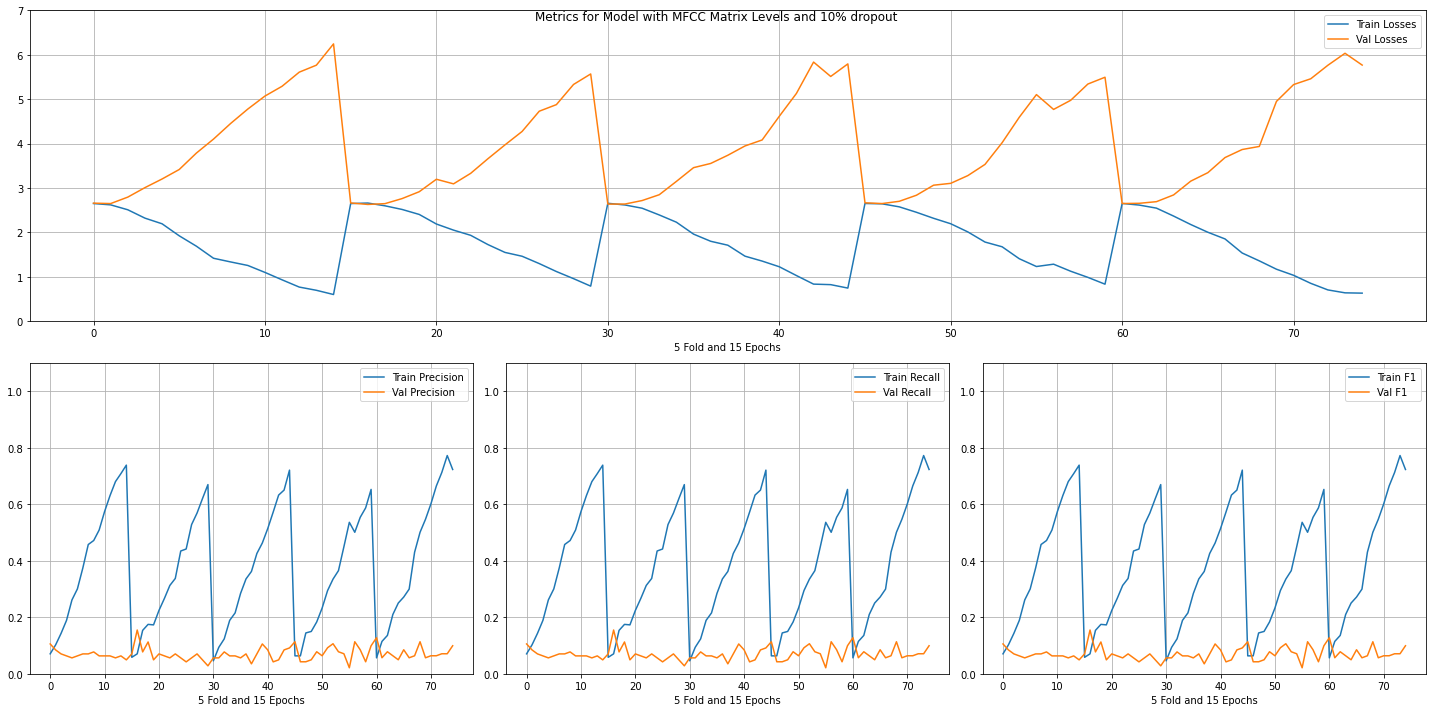

In [44]:
mfcc_matrix_bidir_lstm_results = train_model(data, MfccMatrixDataset.prepare_data, gpu, 
                                  **{'n_labels' : n_labels,
                                   'report' : 20,
                                   'lstm' : True,
                                   'lr' : 5e-3,
                                   'clip_at' : None,
                                   'k_folds' : 5,
                                   'balance_classes' : True,
                                   'dropout' : 0.1,
                                   'title' : 'Model with MFCC Matrix Levels and 10% dropout',
                                   'plot' : True,
                                   'epochs' : 15,
                                   'model' : MfccLstmModel,
                                   'mdlargs' : {'n_layers' : 2}})